In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Installs geemap package
import subprocess

try:
    import geemap
except ImportError:
    print('Installing geemap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

Installing geemap ...


In [3]:
import ee
import os
import datetime
import webbrowser
import geemap
import pprint
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

In [ ]:
ee.Authenticate()
ee.Initialize()

Have a map, you can add things to your map along the way

In [ ]:
Map = geemap.Map()
Map

In [7]:
Roads = ee.FeatureCollection("TIGER/2016/Roads")
filt_roads = Roads.filter(ee.Filter.equals('rttyp', 'I')) #Roadtype, Interstate

In [9]:
os.chdir("/content/drive/MyDrive/Winter_Research")

Export Details

In [98]:
ROI_name = 'KS' #Change depending on what ROI you are using (used for naming files)
save_path = basename + '/' + ROI_name
basename = "RoadpixSentinel"


#These are only important if you want to export as an asset in the future
exportFolder = "users/oqbrady/"
collectionName = "RoadPixSentinel"

In [99]:
cali_pixs = 72264
kansas_pixs = 69071
mont_pixs = 72099
texas_pixs = 71764
ohio_pixs = 62827

In [100]:
cali_roi = ee.Geometry.Polygon([[-120.969389, 37.002966], [-120.859363, 37.015929], [-120.244299, 36.327308], [-120.314643, 36.305507]])
mont_roi = ee.Geometry.Polygon(([[-105.471424, 46.667742], [-105.139824, 46.824933], [-104.850869, 46.966114], [-104.739110, 47.108924], [-104.526622, 47.0799892],
                                 [-104.513387, 47.091907], [-104.753080, 47.15443], [-104.868515, 46.978656], [-105.449642, 46.740551], [-105.482337, 46.740551]]))
texas_roi = ee.Geometry.Polygon(([[-101.257649, 30.693489], [-101.163219, 30.709124], [-100.827636, 30.617001], [-100.311412, 30.464848], [-100.304620, 30.474533],
                                 [-100.492954, 30.568137], [-100.773193, 30.630330], [-101.162826, 30.719190], [-101.260066, 30.702354]]))
kansas_roi = ee.Geometry.Polygon([[-102.477304, 39.300792], [-102.059300, 39.344991], [-101.374279, 39.343892], [-101.362868, 39.327653], [-102.046613, 39.321297], [-102.263878, 39.290923], [-102.47749, 39.289864]])
ohio_roi = ee.Geometry.Polygon([[-84.177001, 40.268322], [-84.153089, 40.328922], [-84.153938, 40.574496], [-83.729733, 40.946666],
                                [-83.777204, 40.975344], [-84.208245, 40.731179], [-84.198750, 40.254644]])

Right now we are going to be looking at the ohio ROI

In [101]:
roi = kansas_roi
max_pixs = int(0.9 * ohio_pixs)

In [102]:
roi = roi
START_DATE = '2016-01-01'
END_DATE = '2019-01-01'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 30
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

In [103]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))
    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

In [104]:
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

In [105]:
def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    #not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

In [106]:
def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focal_min(2).focal_max(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

In [107]:
def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

In [108]:
def ymdList(imgcol):
    def iter_func(image, newlist):
        date = ee.Number.parse(image.date().format("YYYYMMdd"));
        newlist = ee.List(newlist);
        return ee.List(newlist.add(date).sort())
    ymd = imgcol.iterate(iter_func, ee.List([]))
    dates = list(ee.List(ymd).reduce(ee.Reducer.frequencyHistogram()).getInfo().keys())
    return [x[:4] + "-" + x[4:6] + "-" + x[6:] for x in dates]

In [109]:
s2_sr_cld_col_eval = get_s2_sr_cld_col(roi, START_DATE, END_DATE)
imgs_harsh_n = s2_sr_cld_col_eval.map(add_cld_shdw_mask).map(apply_cld_shdw_mask)

In [110]:
#Get a list o dates in the image collection that survived the filtering
dates_to_it = ymdList(imgs_harsh_n)

My attempt at this code

In [111]:
fr = filt_roads.filterBounds(roi)

geo_fr = fr.geometry() #get the geometry of the road
fr_buffer = geo_fr.buffer(20) #set a buffer for twenty meters(can adjust if neccesary)

#now we make it into a feature collection, this will be used interchangeably with fr_buffer
feat = ee.FeatureCollection(fr_buffer)

In [112]:
# I need to convert between different coordinate reference schemes because the census data and images are different.
CRS_pixs = imgs_harsh_n.first().select("B4").projection().getInfo()['crs']
CRS_ll = ee.Image.pixelLonLat().projection().getInfo()['crs']
#trans_ll = ee.Image.pixelLonLat().projection().getInfo()['transform']
#transform = imgs_harsh_n.first().select("B4").projection().getInfo()['transform']

#create a band of all longitudes and latitudes (x,y) and then clip them to just the road
lonlat = ee.Image.pixelCoordinates(CRS_pixs).clip(feat)

In [113]:
#Let's take a look at our feature collection now that we have buffered the roads
Map.addLayer(feat, {}, 'Roads')
Map

This is just for testing purposes. I do this so I know it works on image and then I can run it in a loop.

In [114]:
#This is so we can test our function by only selecting one day

#add longitude and latitude

date = ee.Date(dates_to_it[2])

select_day = imgs_harsh_n.filterDate(date, date.advance(1, 'day'))

mosaic_img = select_day.mosaic().clip(feat)

addBands = mosaic_img.addBands(lonlat)

final_img = addBands.select('B4', 'B3', 'B2', 'x', 'y')


Map.addLayer(final_img)

checkSample = final_img.sample(scale = 10,
                              projection = CRS_pixs,
                              region = fr_buffer)

theTask = ee.batch.Export.table.toDrive(collection = checkSample,
                             description = 'exportTable',
                             folder = 'ATest'
                             )
theTask.start()


In [115]:

'''

function: mosaicSentinel

params:
@imagecollection: Sentinel Mosaic for One Day

Goal: Take a Sentinel Image Collection and Mosaic it to make it into one image. Then clip that image
so only the road has pixels that are non-masked. Add the x,y coordinates we made earlier as well. Finally
select all the bands of interest and return them


'''

def mosaicSentinel(imagecollection):
    
    collection = imagecollection.mosaic().clip(feat) #clip so only get road pixels
    
    addlonlat = collection.addBands(lonlat)
    
    select_bands = addlonlat.select(['B4', 'B3', 'B2', 'x', 'y'])
    
    return select_bands

'''
function: getrgbSentinel

params:
@dates: From our YMDLIST function earlier returns a list of dates to grab Sentinel images from

Goal: Iterate through our dates and list and for every date, run the mosaicSentinel function up above
to get an image of R,G,B,X,Y for each day of interest. Then we use .sample to get a feature collection
of all of the points that are not null on the road (fr_buffer). Finally we export this Feature Collection
as a Excel sheet into google drive (whatever account you use to use Google Earth Engine). Does this for all
dates in YMD List

'''



def getrgbSentinel(dates):
    
    for day in dates:
        
        date = ee.Date(day)
        
        select_day = imgs_harsh_n.filterDate(date, date.advance(1, 'day'))
        
        #runs the function up above
        mosaic_sentinel = mosaicSentinel(select_day)
        
        #return ebery point that is not null on the road, as a feature collection.
        #Look at image.sample if you are interested in the other parameters
        sampleAllPoints = mosaic_sentinel.sample(scale = 10,
                                                projection = CRS_pixs,
                                                region = fr_buffer)
        
        #How every file gets it's unique name
        descript = ROI_name + day + basename
        
        #Export each Excel Sheet as a task to Google Earth Engine as a task
        task = ee.batch.Export.table.toDrive(collection = sampleAllPoints,
                                            description = descript,
                                            folder = save_path)
    
        #start the task
        task.start()

In [116]:
dates_to_it

['2016-01-05',
 '2016-01-15',
 '2016-02-11',
 '2016-03-12',
 '2016-04-14',
 '2016-04-24',
 '2016-05-04',
 '2016-06-13',
 '2016-06-20',
 '2016-06-23',
 '2016-07-10',
 '2016-07-13',
 '2016-07-23',
 '2016-07-30',
 '2016-08-02',
 '2016-08-12',
 '2016-09-11',
 '2016-09-28',
 '2016-10-01',
 '2016-10-18',
 '2016-10-31',
 '2016-11-10',
 '2016-11-17',
 '2016-11-20',
 '2016-11-27',
 '2016-11-30',
 '2016-12-27',
 '2016-12-30',
 '2017-01-19',
 '2017-01-26',
 '2017-01-29',
 '2017-02-15',
 '2017-03-27',
 '2017-04-09',
 '2017-04-16',
 '2017-04-19',
 '2017-05-06',
 '2017-05-26',
 '2017-05-29',
 '2017-06-08',
 '2017-06-15',
 '2017-06-18',
 '2017-06-28',
 '2017-07-05',
 '2017-07-08',
 '2017-07-13',
 '2017-07-18',
 '2017-07-20',
 '2017-07-23',
 '2017-07-25',
 '2017-07-28',
 '2017-08-02',
 '2017-08-09',
 '2017-08-12',
 '2017-08-14',
 '2017-08-17',
 '2017-08-22',
 '2017-08-27',
 '2017-08-29',
 '2017-09-03',
 '2017-09-06',
 '2017-09-11',
 '2017-09-16',
 '2017-09-18',
 '2017-09-21',
 '2017-09-26',
 '2017-10-

In [117]:
save_path

'RoadpixSentinel/KS'

In [118]:
#Actually runs the task
        
runTask = getrgbSentinel(dates_to_it)

In [119]:
runTask

If you want to export the images as an Earth Engine Image Collection this code will help but it is not neccesary for anything you might need.

In [120]:

#assetId = exportFolder + collectionName + '/' + descript

#Export the image to an Earth Engine asset.
        #task = ee.batch.Export.image.toAsset(
        #image = mosaic_sentinel,
        #description= descript,
        #region = fr_buffer,
        #assetId = assetId,
        #scale = 10,
        #maxPixels = 1e13,
        #crs = CRS_pixs)

In [36]:
import pandas as pd

lat_check = pd.read_csv("/content/drive/MyDrive/Ohio/Ohio2016-06-29RoadpixSentinel.csv")

In [33]:
lat_check.head()

,system:index,B2,B3,B4,x,y,.geo
0,0,1100,986,894,769005.0,4535025.0,NaN
1,1,1126,1048,1011,769015.0,4535025.0,NaN
2,2,1297,1198,1220,769025.0,4535025.0,NaN
3,3,1322,1187,1207,769035.0,4535025.0,NaN
4,4,1238,1126,1106,769045.0,4535025.0,NaN


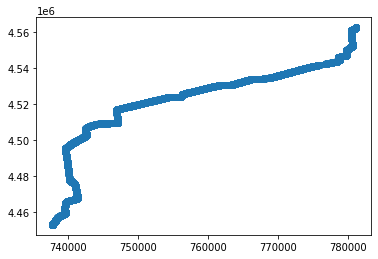

In [37]:
import matplotlib.pyplot as plt

plt.scatter(lat_check["x"], lat_check["y"])